Simple gradient-based quadratic classification model to compute $W$. 

I suspect we'd get very little out of going for something non-linear or higher dimension. We're already getting almost no change on the off-diagonals, so probably not a whole lot going on beyond pairwise interactions.

Positive class performance is poor. Oversampling positive synthetic examples doesn't do much. May get better with real data, since pulling from YC, a16z, etc.

In [1]:
! pip install torch scikit-learn matplotlib -q

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from src.model import sigmoid

np.set_printoptions(precision=2, suppress=True, linewidth=120)


In [3]:
df = pd.read_csv('../data/synth/encoded_founders_composites.csv')
feature_columns = df.columns[:-3]  
X = df[feature_columns].to_numpy()
y = df['success'].values 

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

K = X_norm.shape[1]

# Train/val/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.2, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, shuffle=True
)


In [4]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class QuadraticModel(nn.Module):
    def __init__(self, input_dim):
        super(QuadraticModel, self).__init__()

        from src.model import initialize_weight_matrix
        W_init = torch.FloatTensor(initialize_weight_matrix(input_dim))
        self.W = nn.Parameter(W_init)
        self.b = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        # Ensure W is symmetric
        W_sym = 0.5 * (self.W + self.W.t())
        
        # Compute quadratic form for each sample in the batch
        batch_size = x.size(0)
        scores = torch.zeros(batch_size, device=x.device)
        
        for i in range(batch_size):
            scores[i] = torch.matmul(torch.matmul(x[i], W_sym), x[i])
        
        return torch.sigmoid(scores + self.b)
    
    def get_W(self):
        return 0.5 * (self.W + self.W.t())

model = QuadraticModel(K)
W_init = model.get_W().detach().clone()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

epochs = 100
train_loss_history = []
val_loss_history = []
test_loss_history = []
train_acc_history = []
val_acc_history = []
test_acc_history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        # Forward
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * X_batch.size(0)
        
        # Calculate accuracy
        predicted = (y_pred > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss = epoch_loss / len(train_dataset)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_preds = (val_outputs > 0.5).float()
        val_acc = (val_preds == y_val_tensor).float().mean().item()
        
        test_outputs = model(X_test_tensor).squeeze()
        test_loss = criterion(test_outputs, y_test_tensor).item()
        test_preds = (test_outputs > 0.5).float()
        test_acc = (test_preds == y_test_tensor).float().mean().item()
    
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    
    scheduler.step(val_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Test Loss = {test_loss:.4f}, "
              f"Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, Test Acc = {test_acc:.4f}")

W = model.get_W().detach().numpy()
b = model.b.item()

Epoch 0: Train Loss = 62.6500, Val Loss = 62.5500, Test Loss = 61.7000, Train Acc = 0.3735, Val Acc = 0.3745, Test Acc = 0.3830
Epoch 10: Train Loss = 5.0723, Val Loss = 5.0199, Test Loss = 4.6700, Train Acc = 0.7793, Val Acc = 0.7490, Test Acc = 0.7595
Epoch 20: Train Loss = 5.0653, Val Loss = 4.9992, Test Loss = 4.6408, Train Acc = 0.7803, Val Acc = 0.7615, Test Acc = 0.7655
Epoch 30: Train Loss = 4.3961, Val Loss = 4.6430, Test Loss = 4.1837, Train Acc = 0.7895, Val Acc = 0.7835, Test Acc = 0.7835
Epoch 40: Train Loss = 3.5523, Val Loss = 3.9851, Test Loss = 3.4175, Train Acc = 0.7920, Val Acc = 0.7885, Test Acc = 0.7875
Epoch 50: Train Loss = 2.7742, Val Loss = 2.8950, Test Loss = 2.3433, Train Acc = 0.7862, Val Acc = 0.7840, Test Acc = 0.8020
Epoch 60: Train Loss = 2.7526, Val Loss = 2.9124, Test Loss = 2.3487, Train Acc = 0.7795, Val Acc = 0.7660, Test Acc = 0.7835
Epoch 70: Train Loss = 2.7601, Val Loss = 2.9018, Test Loss = 2.3751, Train Acc = 0.7833, Val Acc = 0.7945, Test Acc

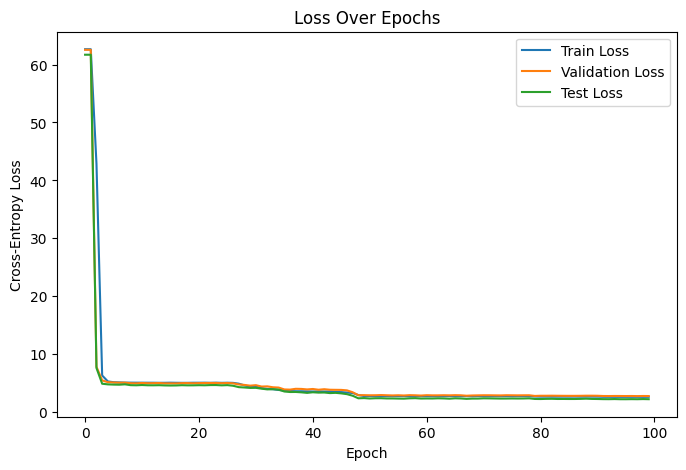

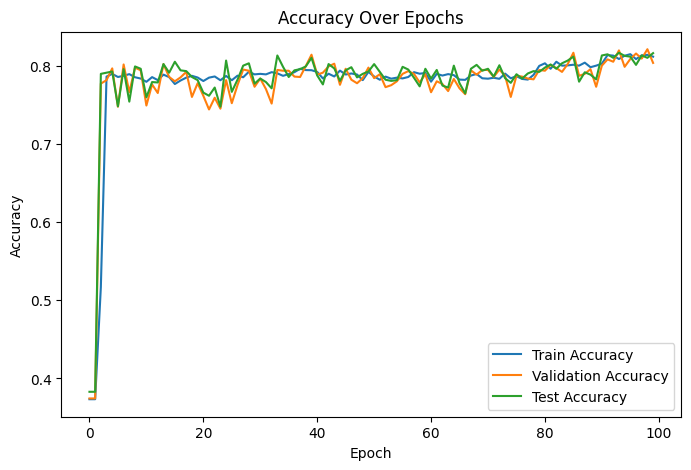

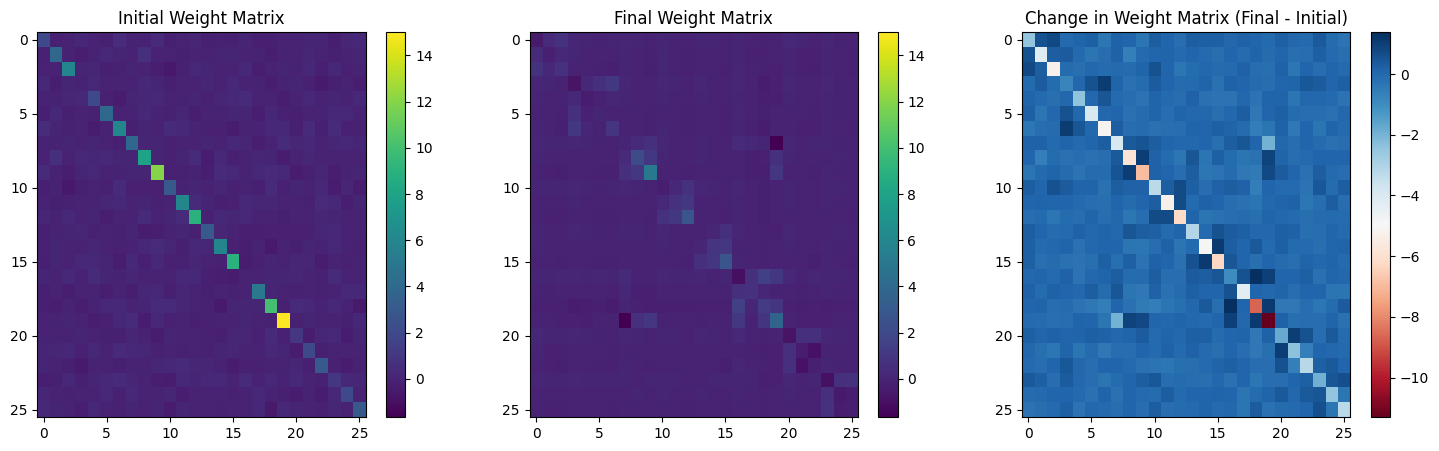

In [5]:
# Plot training, validation, and test loss curves.
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.plot(test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

vmin = min(W_init.min(), W.min())
vmax = max(W_init.max(), W.max())

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
im0 = axs[0].imshow(W_init, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("Initial Weight Matrix")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(W, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("Final Weight Matrix")
plt.colorbar(im1, ax=axs[1])
W_init_numpy = W_init.numpy()  # Convert tensor to numpy
W_diff = W - W_init_numpy
im2 = axs[2].imshow(W_diff, aspect='auto', cmap='RdBu')
axs[2].set_title("Change in Weight Matrix (Final - Initial)")
plt.colorbar(im2, ax=axs[2])
plt.show()

In [6]:
# print(np.diag(W))
# print(np.diag(W_init))
# print(np.diag(np.abs(W-W_init)))

In [7]:
# import pickle
# import re

# filename = '../models/26x26/W_1.pkl'
# new_filename = re.sub(r'(\d+)', lambda x: str(int(x.group(1)) + 1), filename, count=1)

# with open(new_filename, 'wb') as f:
#     pickle.dump(W, f)

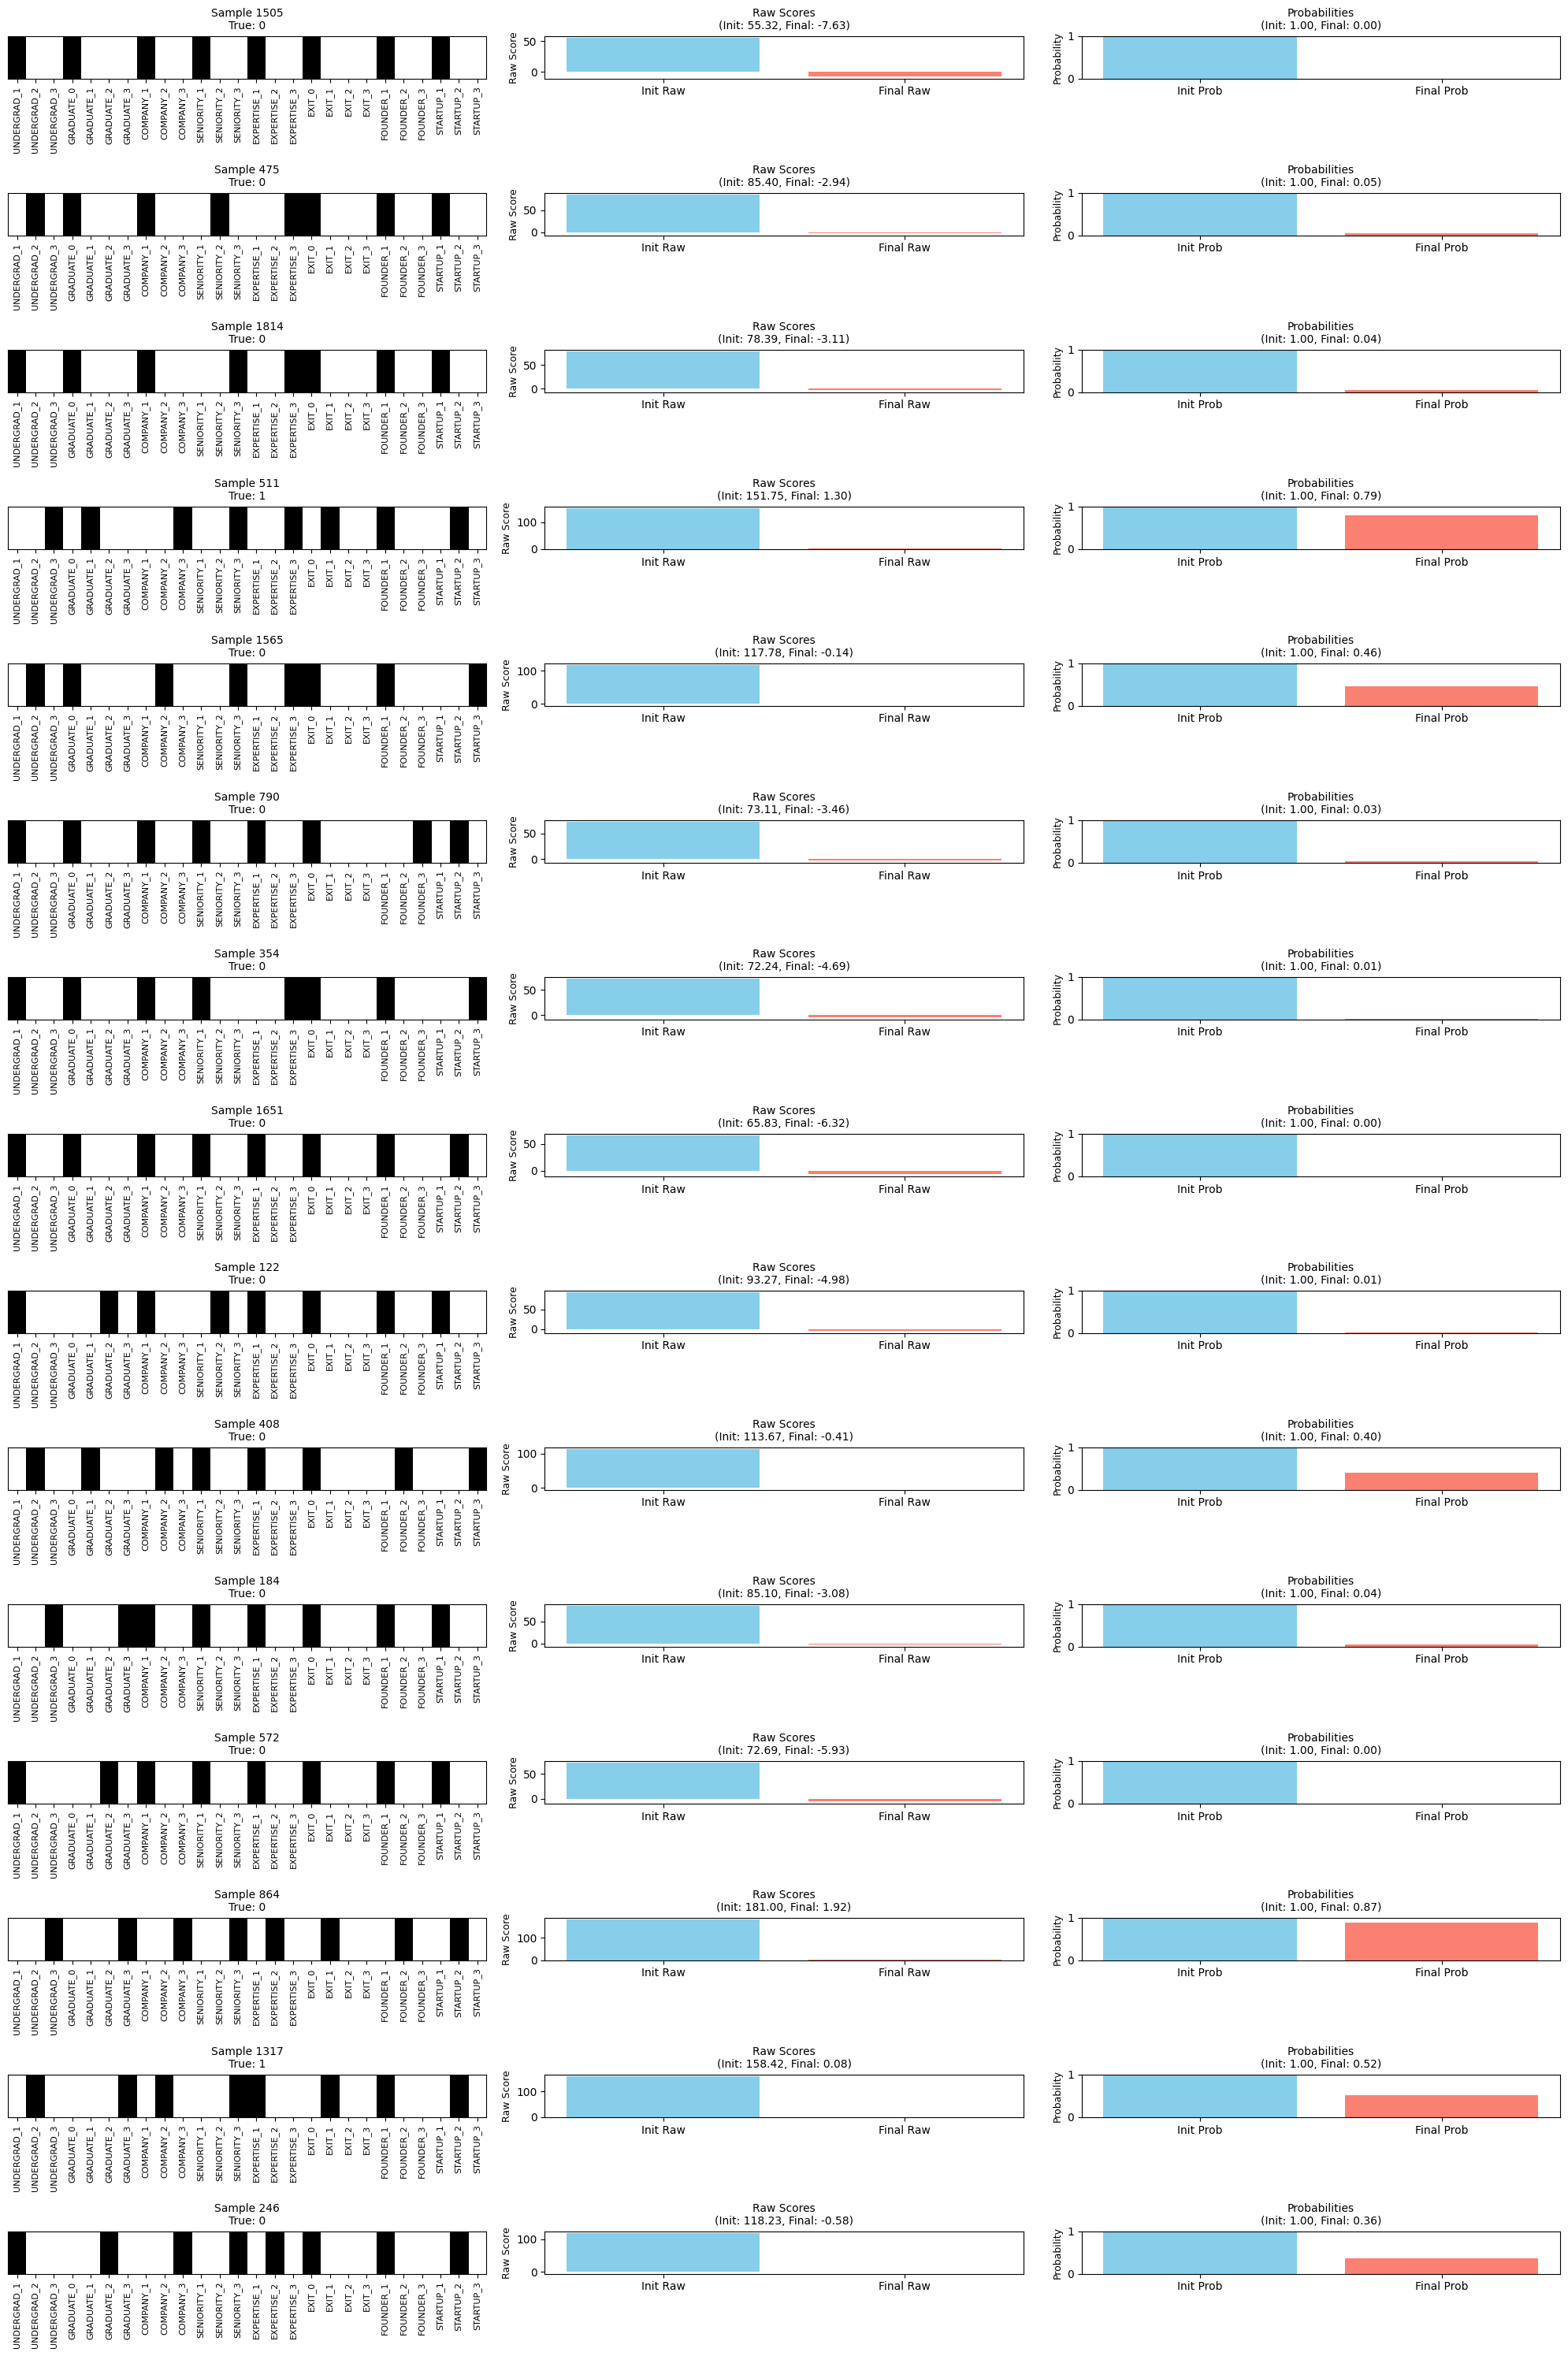

In [8]:
X_raw = df[feature_columns].to_numpy()

X_raw_train, X_raw_test, _, _ = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, shuffle=True
)

n_samples = 15
selected_indices = np.random.choice(len(X_test), size=n_samples, replace=False)
selected_samples = X_test[selected_indices]
selected_y_true = y_test[selected_indices]
selected_raw_attributes = X_raw_test[selected_indices]

W_init_numpy = W_init.numpy()  # Convert tensor to numpy
raw_scores_init = np.array([x.T @ W_init_numpy @ x for x in selected_samples])
raw_scores_final = np.array([x.T @ W @ x + b for x in selected_samples])


p_init = sigmoid(raw_scores_init)
p_final = sigmoid(raw_scores_final)

fig, axs = plt.subplots(n_samples, 3, figsize=(20, 2 * n_samples))
if n_samples == 1:
    axs = axs[np.newaxis, :]

for i in range(n_samples):
    ax_attr = axs[i, 0]
    sample_data = selected_raw_attributes[i].reshape(1, -1)
    im = ax_attr.imshow(sample_data, cmap='Greys', aspect='auto')
    ax_attr.set_yticks([])
    ax_attr.set_xticks(np.arange(len(feature_columns)))
    ax_attr.set_xticklabels(feature_columns, rotation=90, fontsize=8)
    ax_attr.set_title(f"Sample {selected_indices[i]}\nTrue: {selected_y_true[i]}", fontsize=10)
    
    ax_raw = axs[i, 1]
    categories = ['Init Raw', 'Final Raw']
    raw_vals = [raw_scores_init[i], raw_scores_final[i]]
    ax_raw.bar(categories, raw_vals, color=['skyblue', 'salmon'])
    ax_raw.set_ylabel("Raw Score", fontsize=9)
    ax_raw.set_title(f"Raw Scores\n(Init: {raw_scores_init[i]:.2f}, Final: {raw_scores_final[i]:.2f})", fontsize=10)
    
    ax_prob = axs[i, 2]
    prob_categories = ['Init Prob', 'Final Prob']
    prob_vals = [p_init[i], p_final[i]]
    ax_prob.bar(prob_categories, prob_vals, color=['skyblue', 'salmon'])
    ax_prob.set_ylim(0, 1)
    ax_prob.set_ylabel("Probability", fontsize=9)
    ax_prob.set_title(f"Probabilities\n(Init: {p_init[i]:.2f}, Final: {p_final[i]:.2f})", fontsize=10)

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import classification_report

with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_probs = test_outputs.numpy()  # Convert to numpy array


test_preds = (test_probs > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, test_preds))



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.81      0.84      1234
           1       0.73      0.83      0.78       766

    accuracy                           0.82      2000
   macro avg       0.81      0.82      0.81      2000
weighted avg       0.82      0.82      0.82      2000

